In [2]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm

from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import *
from models import *
from training import LogL1Loss

# torch._dynamo.config.suppress_errors = True

ModuleNotFoundError: No module named 'DGBaN'

Load dataset:

In [28]:
data_size = 640_000
data_gen = single_random_ring(N=32)
X, y = data_gen.generate_dataset(data_size=data_size, noise=True, sigma=0.03, seed=42, device='cpu', test_return=True)

tensor([[0.5333, 0.4667, 0.9697, 0.3671, 0.5157, 0.5556]])


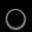

In [52]:
i = np.random.choice(data_size)
X_ = torch.Tensor(X[i].reshape(1, -1))
print(X_)
Image.fromarray((y[i] * 255).astype(np.uint8))

Test generator:

In [89]:
state_dict = torch.load(
    '../save_data/single_random_ring/Adam_mse_loss/DGBaNR_3_base_sigmoid/DGBaNR_3_base_sigmoid_6.pt',
    map_location=torch.device('cpu')
)

S = 0
for val in state_dict.values():
    S += np.prod(val.size())

S

6289419.0

In [5]:
np.random.choice([0, 1, 2, 3], size=3)

array([0, 2, 1])

In [57]:
# load generator
generator = DGBaNR_2(data_gen.n_features, 32, 'sigmoid')
# generator = torch.compile(generator)

pre_trained_weights = torch.load(
    '../save_data/single_random_ring/Adam_mse_loss_5/DGBaNR_2_sigmoid/DGBaNR_2_sigmoid_2.pt',
    map_location=torch.device('cpu')
)
generator.load_state_dict(pre_trained_weights)

print(generator.eval())
print('Number of parameters:', sum(p.numel() for p in generator.parameters()))

DGBaNR_2(
  (linear_1): LinearReparameterization()
  (linear_2): LinearReparameterization()
  (linear_3): LinearReparameterization()
  (conv_1): ConvTranspose2dReparameterization()
  (batch_norm_1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): ConvTranspose2dReparameterization()
  (batch_norm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): ConvTranspose2dReparameterization()
)
Number of parameters: 21846274


In [85]:
y_pred = np.zeros((5, 64, 32, 32))
for j in range(5):
    y_pred[j] = generator(torch.Tensor(X[64:128]).clone())[0].detach().numpy().squeeze()

y_pred = y_pred.mean(axis=0)

print(((y_pred - y[64:128])**2).mean()/2)
# Image.fromarray((abs(y_pred) / y_pred.max()  * 255).astype(np.uint8()))

0.005815035226146859


In [71]:
# setting the base feature
n_samples = 5

# getting the predictions for this feature
pred_rings = np.zeros((n_samples, 32, 32))
with torch.no_grad():
    for j in range(n_samples):
        pred_rings[j] += generator(X_)[0].detach().numpy().squeeze()
pred_ring = pred_rings.sum(axis=0)

# summing the predictions
pred_prob = pred_ring * 255 / pred_ring.max()
true_prob = data_gen.gaussian_from_features(*data_gen.scaler.inverse_transform(X_)[0].tolist()) * 255

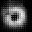

In [72]:
# predicted gaussian ring
Image.fromarray(abs(pred_prob).astype(np.uint8))

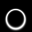

In [74]:
# true gaussian ring
Image.fromarray(true_prob.astype(np.uint8))

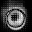

In [75]:
# difference between the rings
Image.fromarray(np.abs(true_prob - pred_prob).astype(np.uint8))

In [76]:
# MSE error
((pred_prob / pred_prob.max() - true_prob / true_prob.max())**2).mean()

0.11915152819070232

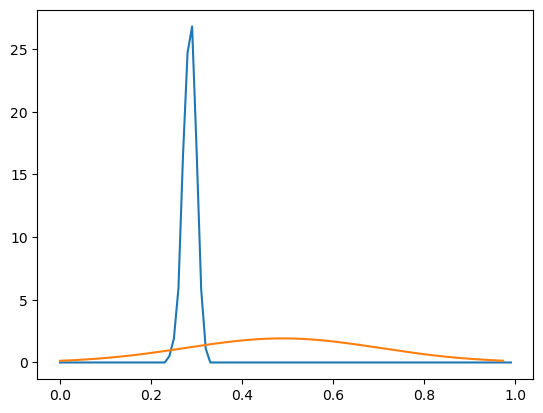

In [52]:
# getting the distribution for one pmt
pmt = (16, 17)
pred = pd.Series(pred_rings[:, pmt[0], pmt[1]])
hist = pd.Series(1, index=pd.cut(pred, np.arange(0, 1.01, 0.01))).sort_index().groupby(level=0).sum()
pred_noise = hist / (hist.sum() * 0.01)

plt.plot(np.arange(0, 1, 0.01), pred_noise)

val = np.arange(0, 2, 0.01) * true_prob[pmt] / (2 * 255)
true_pmt_distr = np.exp(-(val - true_prob[pmt] / (2 * 255))**2 / 0.3**2)
true_pmt_distr /= true_pmt_distr.sum() * 0.01 * true_prob[pmt] / (2 * 255)
plt.plot(val, true_pmt_distr)
plt.show()